<a href="https://colab.research.google.com/github/juanmggb/maestria/blob/main/parameter_estimation/parameter_estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install pyDOE

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for pyDOE: filename=pyDOE-0.3.8-py3-none-any.whl size=18184 sha256=6c887ddb82dd83af249ffbf7038109e083485faac4e1967d4e27848c77543445
  Stored in directory: /root/.cache/pip/wheels/00/3e/fa/5705bf59c2053c17c4799c3ab66a2e356c32f40a3044fe2134
Successfully built pyDOE


In [2]:
pip install geneticalgorithm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 KB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for func-timeout: filename=func_timeout-4.3.5-py3-none-any.whl size=15096 sha256=8ca03f3a5d9d9bd8580d47f569676ecf68a58cde4de261a3df49d5da435dfd77
  Stored in directory: /root/.cache/pip/wheels/a8/92/ca/5bbab358275e310af23b73fc32ebf37d6a7a08c87c8d2cdbc1
Successfully built func-timeout


In [3]:
# Import libraries
import numpy as np 
import matplotlib.pyplot as plt
from geneticalgorithm import geneticalgorithm as ga
import pandas as pd  
import sys
from scipy.integrate import odeint
from time import time as clock
import random

In [4]:
# In order to access the package you need to have its path. The path required is the path WHERE that package is soterd, not it path
# sys.path.insert(1, 'd:\\DYNAMICAL SIMULATION\\maestria\\maestria')

In [5]:
!git clone https://github.com/juanmggb/maestria.git

Cloning into 'maestria'...
remote: Enumerating objects: 339, done.
remote: Counting objects: 100% (136/136), done.
remote: Compressing objects: 100% (130/130), done.
remote: Total 339 (delta 63), reused 18 (delta 6), pack-reused 203
Receiving objects: 100% (339/339), 9.56 MiB | 6.75 MiB/s, done.
Resolving deltas: 100% (148/148), done.


In [6]:
cd maestria

/content/maestria


In [7]:
import utilis.functions as fn
from utilis.models import monod_model, inhibition_model

In [8]:
# Definir parametros 
mu_max = 1.2 # g/L
yxs = 0.2 
ks = 280 # g/L
ypx = 4 
ki = 0.3 # L/g

# I need to move this functions later

In [9]:
def plot_simulated_data(data):
    plt.figure(figsize=(10, 5))
    plt.scatter(data.t, data.x, label = 'biomass')
    plt.scatter(data.t, data.s, label = 'substrate')
    plt.scatter(data.t, data.p, label = 'product')
    plt.xlabel("Time (h)", size = 20)
    plt.ylabel('Concentration (g/L)', size = 20)
    plt.grid()
    plt.legend(fontsize=10)
    plt.show()

In [10]:
def fitness_function_monod(parms):
    mu_max, yxs, ks, ypx = parms
    # Definir condiciones iniciales 
    x0 = np.array([0.2, 40, 0])
    # Definir tiempo de integracion 
    tf = 60 
    dt = 1 
    time = np.arange(0, tf+dt, dt)
    x, s, p =  odeint(monod_model, x0, time, args =(0, mu_max, yxs, ks, ypx,)).T
    out = fn.create_df(time, x, s, p)
    return fn.MSE(data_monod, out)

In [11]:
def fitness_function_inhibition(parms):
    mu_max, yxs, ks, ypx, ki = parms
    # Definir condiciones iniciales 
    x0 = np.array([0.2, 40, 0])
    # Definir tiempo de integracion 
    tf = 60 
    dt = 1 
    time = np.arange(0, tf+dt, dt)
    x, s, p =  odeint(inhibition_model, x0, time, args =(0, mu_max, yxs, ks, ypx, ki, )).T
    out = fn.create_df(time, x, s, p)
    return fn.MSE(data_inhibition, out)

In [12]:
def calculate_stats(params):
    mean_values = np.mean(params, axis=0)
    std_values =  np.std(params, axis=0)
    stats = []
    for i in range(len(mean_values)):
        mean_value = mean_values[i]
        std_value = std_values[i]
        lower = mean_value - 1.96*std_value/np.sqrt(params.shape[0])
        upper = mean_value + 1.96*std_value/np.sqrt(params.shape[0])
        stats.append((mean_value, std_value, lower, upper))

    return stats

In [13]:
def plot_stats(data, real_value, y_label):
        
    mean = np.mean(data)
    confidence_interval = 1.96 * np.std(data) / np.sqrt(len(data))

    # Dibuja la gráfica
    plt.errorbar(1, mean, yerr=confidence_interval, fmt="o", color="red", label="Valor promedio")
    plt.scatter(np.full_like(data, 2), data, label = 'Estimado')
    plt.plot(3, real_value, "o", color="blue", label="Valor real")
    plt.xlim(0, 4)
    plt.xticks([1, 2, 3], ["Valor promedio","Estimado", "Valor real"], size = 10)
    plt.ylabel(y_label, size = 20)
    plt.legend()

# Load data

In [14]:
# Load data 
data_monod = pd.read_csv("data/data_monod.csv")
data_monod.head()

,t,x,s,p
0,0,0.242723,39.673568,0.320286
1,1,0.178948,39.776111,0.085047
2,2,0.325052,40.449577,0.366801
3,3,0.329567,40.093182,1.454305
4,4,0.425727,39.620962,1.313975


In [15]:
# Load data 
data_inhibition = pd.read_csv("data/data_inhibition.csv")
data_inhibition.head()

,t,x,s,p
0,0,0.174614,40.745821,1.081127
1,1,-0.060982,38.007323,-1.422682
2,2,0.087718,40.599858,-1.457520
3,3,0.242266,39.281919,0.688872
4,4,0.256444,40.626491,-0.866604


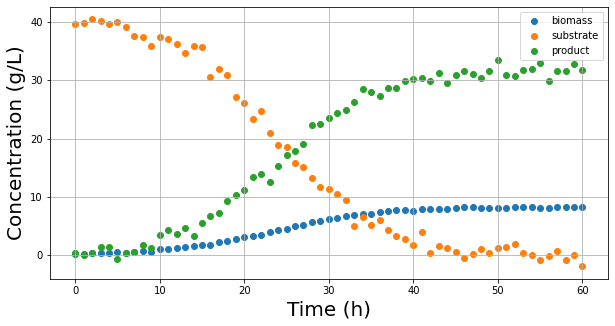

In [16]:
plot_simulated_data(data_monod)

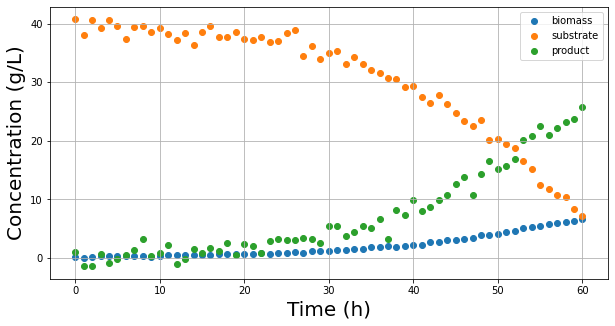

In [17]:
plot_simulated_data(data_inhibition)

In [18]:
fitness_function_monod([mu_max, yxs, ks, ypx])

1.8223412247601742

In [19]:
fitness_function_inhibition([mu_max, yxs, ks, ypx, ki])

2.221335566886478

In [20]:
# Configuramos algoritmo genetico
algorithm_param = {'max_num_iteration': 50,\
                   'population_size':50,\
                   'mutation_probability':0.2,\
                   'elit_ratio': 0.01,\
                   'crossover_probability': 0.8,\
                   'parents_portion': 0.5,\
                   'crossover_type':'uniform',\
                   'max_iteration_without_improv':None}

# Monod

In [21]:
# Establecer los rangos de busqueda para las variables de decision
varbound_monod=np.array([
    [1,3], # mu_max
    [0.05,1], # yxs
    [200,300], # ks
    [1,10] # ypx
])

In [22]:
model_monod=ga(function=fitness_function_monod,
         dimension=4,
         variable_type='real',
         variable_boundaries=varbound_monod,
         algorithm_parameters=algorithm_param)

 The best solution found:
 [1.22302517e+00 2.20533694e-01 2.71822175e+02 3.50493873e+00]

 Objective function:
 2.7282543030315525


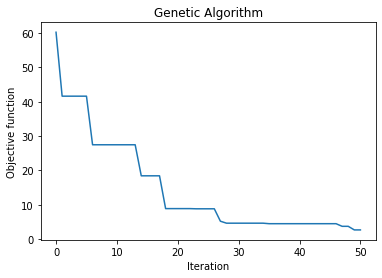

 The best solution found:
 [1.03544828e+00 1.15494274e-01 2.82937586e+02 6.88483052e+00]

 Objective function:
 8.96894656716411


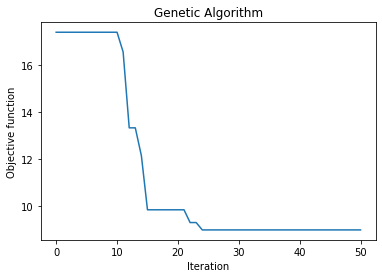

 The best solution found:
 [1.09032452e+00 2.26443701e-01 2.48240619e+02 3.50349739e+00]

 Objective function:
 2.3071821029267934


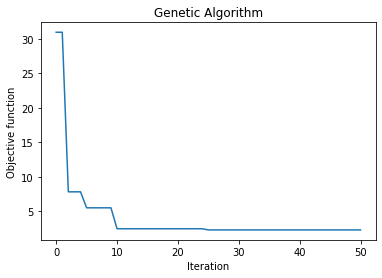

 The best solution found:
 [1.26959892e+00 2.08582363e-01 2.99357369e+02 3.82990756e+00]

 Objective function:
 1.7759117573421026


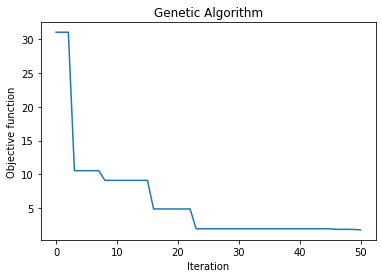

 The best solution found:
 [1.31006176e+00 2.37344524e-01 2.92519532e+02 3.05868596e+00]

 Objective function:
 6.268798370801121


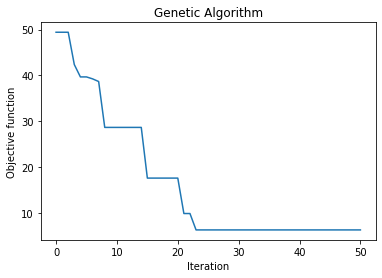

In [23]:
random.seed(73)
best_function_monod = []
best_values_monod = np.zeros((5, varbound_monod.shape[0]))
# Realizar la busqueda
start_time = clock()
for i in range(5):
    model_monod.run()
    best_function_monod.append(model_monod.best_function)
    best_values_monod[i,:] = model_monod.best_variable
end_time = clock()

In [24]:
total_time = end_time - start_time
print(f"Total time: {total_time:.3f}s")

Total time: 21.331s


In [25]:
print("Minimun fitness value:")
for best_function in best_function_monod:
    print(best_function)

Minimun fitness value:
2.7282543030315525
8.96894656716411
2.3071821029267934
1.7759117573421026
6.268798370801121


In [26]:
print("Average minimum function value:", np.mean(best_function_monod))

Average minimum function value: 4.4098186202531355


In [27]:
print('Best solution found:')
for best_variables in best_values_monod: 
    print(best_variables)

Best solution found:
[1.22302517e+00 2.20533694e-01 2.71822175e+02 3.50493873e+00]
[1.03544828e+00 1.15494274e-01 2.82937586e+02 6.88483052e+00]
[1.09032452e+00 2.26443701e-01 2.48240619e+02 3.50349739e+00]
[1.26959892e+00 2.08582363e-01 2.99357369e+02 3.82990756e+00]
[1.31006176e+00 2.37344524e-01 2.92519532e+02 3.05868596e+00]


In [28]:
stats_monod = calculate_stats(best_values_monod)

In [29]:
for stats in stats_monod:
    print(stats)

(1.1856917290260836, 0.10542305768777589, 1.09328434465887, 1.278099113393297)
(0.20167971111393243, 0.0440823840097838, 0.1630397978695309, 0.24031962435833396)
(278.97545603758226, 17.94637858469351, 263.24476163117635, 294.7061504439882)
(4.156372033599299, 1.3861161664775319, 2.9413876442008693, 5.371356422997728)


mu_max = 1.2  g/L

yxs = 0.2 

ks = 280  g/L

ypx = 4 

# Inhibition model

In [30]:
# Establecer los rangos de busqueda para las variables de decision
varbound_inhibition=np.array([
    [1,3], # mu_max
    [0.05,1], # yxs
    [200,300], # ks
    [1,10], # ypx
    [0.05,0.5] # ki
])

In [31]:
model_inhibition=ga(function=fitness_function_inhibition,
         dimension=5,
         variable_type='real',
         variable_boundaries=varbound_inhibition,
         algorithm_parameters=algorithm_param)

 The best solution found:
 [1.21353834e+00 2.03614808e-01 2.19943466e+02 3.78402841e+00
 3.54903456e-01]

 Objective function:
 2.5884303388595957


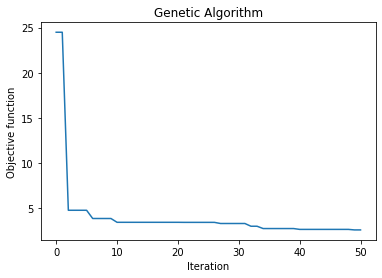

 The best solution found:
 [1.29308646e+00 1.98482231e-01 2.68163036e+02 4.07927180e+00
 3.63575628e-01]

 Objective function:
 2.4988664279602206


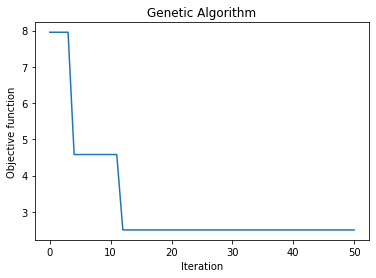

 The best solution found:
 [1.21457032e+00 1.79379009e-01 2.93946737e+02 4.55008314e+00
 3.14004854e-01]

 Objective function:
 2.444287142242343


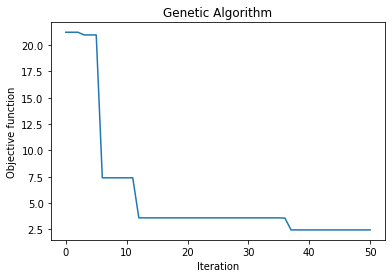

 The best solution found:
 [  1.56982431   0.33505069 289.39634305   2.23719773   0.36546322]

 Objective function:
 6.89737110164974


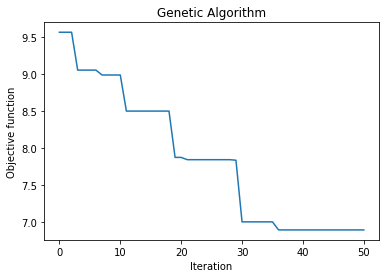

 The best solution found:
 [1.14472868e+00 2.48353526e-01 2.82136135e+02 3.50990250e+00
 2.40312574e-01]

 Objective function:
 3.423357164423025


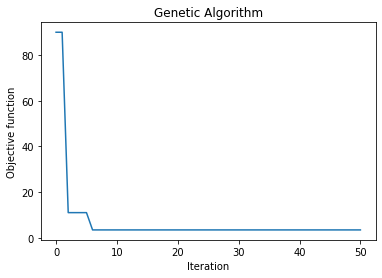

 The best solution found:
 [1.08919400e+00 2.78268938e-01 2.40091178e+02 2.66405439e+00
 2.23127036e-01]

 Objective function:
 4.256821436945343


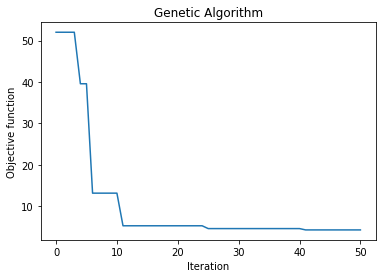

 The best solution found:
 [1.21850285e+00 1.32692851e-01 2.26153581e+02 5.58554928e+00
 4.38111993e-01]

 Objective function:
 3.1309986513188077


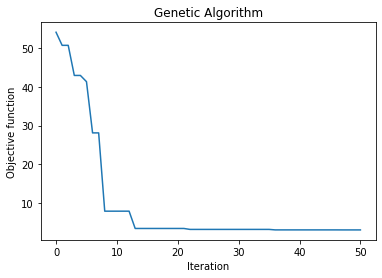

 The best solution found:
 [1.12469274e+00 2.36374099e-01 2.43963974e+02 3.25384642e+00
 2.65744175e-01]

 Objective function:
 2.5998240480363197


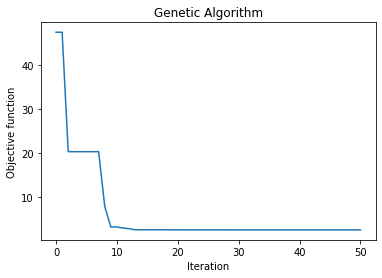

 The best solution found:
 [  1.30475043   0.27838039 245.46223725   2.64050762   0.32081731]

 Objective function:
 4.407633646801276


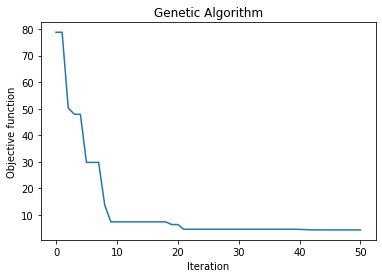

 The best solution found:
 [1.43652116e+00 2.02523661e-01 2.69909802e+02 3.69891005e+00
 4.15360469e-01]

 Objective function:
 2.587650073615891


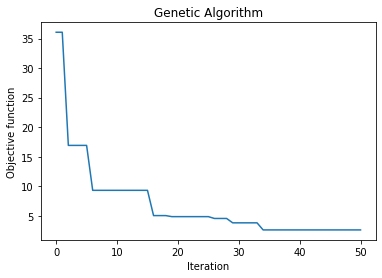

In [42]:
best_function_inhibition = []
best_values_inhibition = np.zeros((10, varbound_inhibition.shape[0]))
# Realizar la busqueda
start_time = clock()
for i in range(10):
    model_inhibition.run()
    best_function_inhibition.append(model_inhibition.best_function)
    best_values_inhibition[i,:] = model_inhibition.best_variable
end_time = clock()

In [43]:
total_time_inhibition = end_time - start_time
print(f"Total time: {total_time_inhibition:.3f}s")

Total time: 36.523s


In [44]:
print("Minimun fitness value:")
for best_function in best_function_inhibition:
    print(best_function)

Minimun fitness value:
2.5884303388595957
2.4988664279602206
2.444287142242343
6.89737110164974
3.423357164423025
4.256821436945343
3.1309986513188077
2.5998240480363197
4.407633646801276
2.587650073615891


In [45]:
print("Average minimum function value:", np.mean(best_function_inhibition))

Average minimum function value: 3.4835240031852566


In [46]:
print('Best solution found:')
for best_variables in best_values_inhibition: 
    print(best_variables)

Best solution found:
[1.21353834e+00 2.03614808e-01 2.19943466e+02 3.78402841e+00
 3.54903456e-01]
[1.29308646e+00 1.98482231e-01 2.68163036e+02 4.07927180e+00
 3.63575628e-01]
[1.21457032e+00 1.79379009e-01 2.93946737e+02 4.55008314e+00
 3.14004854e-01]
[  1.56982431   0.33505069 289.39634305   2.23719773   0.36546322]
[1.14472868e+00 2.48353526e-01 2.82136135e+02 3.50990250e+00
 2.40312574e-01]
[1.08919400e+00 2.78268938e-01 2.40091178e+02 2.66405439e+00
 2.23127036e-01]
[1.21850285e+00 1.32692851e-01 2.26153581e+02 5.58554928e+00
 4.38111993e-01]
[1.12469274e+00 2.36374099e-01 2.43963974e+02 3.25384642e+00
 2.65744175e-01]
[  1.30475043   0.27838039 245.46223725   2.64050762   0.32081731]
[1.43652116e+00 2.02523661e-01 2.69909802e+02 3.69891005e+00
 4.15360469e-01]


In [47]:
stats_inhibition = calculate_stats(best_values_inhibition)

In [48]:
for stats in stats_inhibition:
    print(stats)

(1.260940928145776, 0.14034032294397358, 1.1739570948047335, 1.3479247614868184)
(0.22931202094217706, 0.05527622628195242, 0.19505146094225032, 0.2635725809421038)
(257.9166489788788, 24.985872226499193, 242.43024492878953, 273.4030530289681)
(3.600335131444035, 0.9434089040196509, 3.0156042347333205, 4.18506602815475)
(0.3301420706003097, 0.06776001625044568, 0.2881439774145893, 0.3721401637860301)


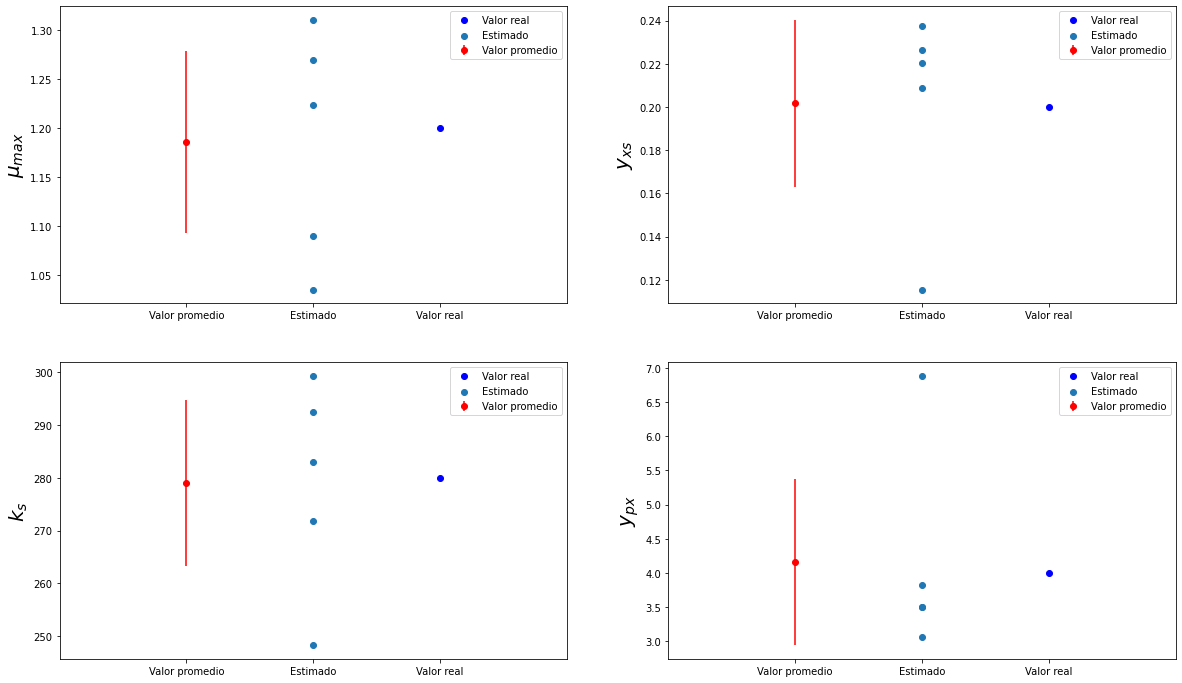

In [49]:
plt.figure(figsize=(20,12))
plt.subplot(2,2, 1)
plot_stats(best_values_monod[:, 0], mu_max, "$\mu_{max}$")
plt.subplot(2,2, 2)
plot_stats(best_values_monod[:, 1], yxs, "$y_{xs}$")
plt.subplot(2,2, 3)
plot_stats(best_values_monod[:, 2], ks, "$k_s$")
plt.subplot(2,2, 4)
plot_stats(best_values_monod[:, 3], ypx, "$y_{px}$")
plt.show()

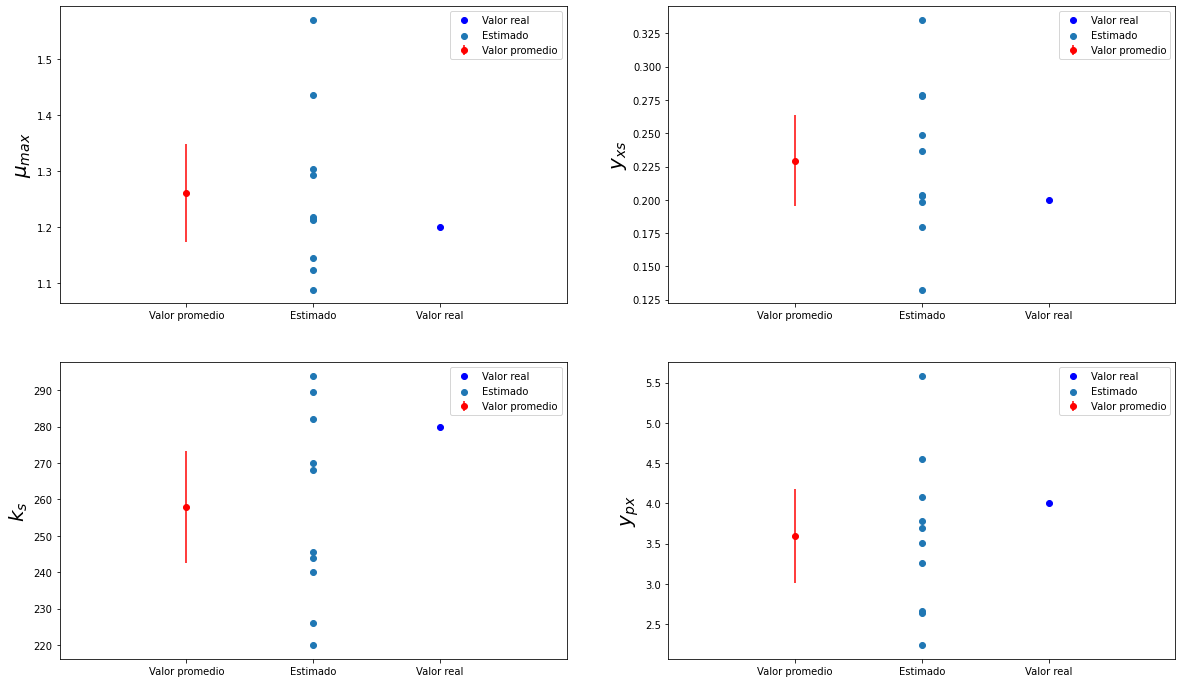

In [50]:
plt.figure(figsize=(20,12))
plt.subplot(2,2, 1)
plot_stats(best_values_inhibition[:, 0], mu_max, "$\mu_{max}$")
plt.subplot(2,2, 2)
plot_stats(best_values_inhibition[:, 1], yxs, "$y_{xs}$")
plt.subplot(2,2, 3)
plot_stats(best_values_inhibition[:, 2], ks, "$k_s$")
plt.subplot(2,2, 4)
plot_stats(best_values_inhibition[:, 3], ypx, "$y_{px}$")
plt.show()

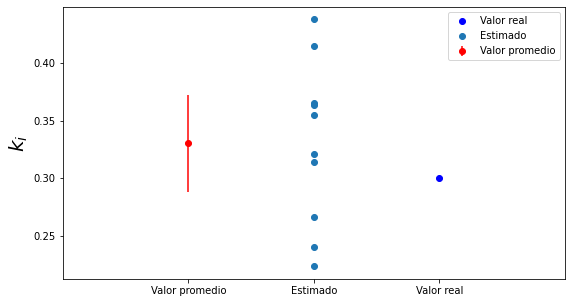

In [51]:
plt.figure(figsize=(9,5))
plot_stats(best_values_inhibition[:, 4], ki, "$k_i$")
plt.show()